In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
!pip install annoy
!pip install surprise
!pip install torch
!pip install torch_geometric
!pip install torchviz
!pip install transformers
!pip install wordcloud

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold
from annoy import AnnoyIndex

from wordcloud import WordCloud

from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split as srp_train_test_split
from surprise import accuracy as srp_accuracy
from surprise.model_selection import KFold as srp_KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import degree

import networkx as nx

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset

## Display all the columns of the dataframe
pd.pandas.set_option('display.max_columns',None)

In [11]:
dataset = pd.read_json(r'C:\Users\kisha\Downloads\renttherunway_final_data.json', lines=True)
print(dataset.shape)

(192544, 15)


In [12]:
dataset.head(20)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45.0,"April 30, 2016"
6,fit,336066,34c,568429,112lbs,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27.0,"December 7, 2017"
7,fit,86661,34d+,130259,118lbs,10.0,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,"5' 3""",8,65.0,"January 1, 2013"
8,fit,166228,36d,1729232,NaN,10.0,formal affair,I was nervous of it looking cheap when it arri...,full bust,Great for black tie event!,gown,"5' 6""",21,27.0,"June 27, 2016"
9,fit,154309,32b,1729232,114lbs,10.0,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,"5' 3""",1,33.0,"October 17, 2016"


For the record, Our target variable is 'fit' and the rest of the column will serve as a feature variable for our model.

In [13]:
dataset.columns

Index(['fit', 'user_id', 'bust size', 'item_id', 'weight', 'rating',
       'rented for', 'review_text', 'body type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date'],
      dtype='object')

In [14]:
dataset.columns = ['fit', 'user_id', 'bust_size', 'item_id', 'weight', 'rating',
       'rented_for', 'review_text', 'body_type', 'review_summary', 'category',
       'height', 'size', 'age', 'review_date'] #removed blank space from feature names

In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented_for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


# Data Understanding and Preprocessing:
We can clearly see that the data has missing values in both numerical and string data. Hence, we might need to handle this first.

In [16]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
features_with_na=[features for features in dataset.columns if dataset[features].isnull().sum()>1]

## 2- step print the feature name and the percentage of missing values
for feature in features_with_na:
    print(feature, '->', (dataset[feature].isnull().sum()/192544*100),  '% Missing Values')

bust_size -> 9.561970250955627 % Missing Values
weight -> 15.571505733754362 % Missing Values
rating -> 0.04258766827322586 % Missing Values
rented_for -> 0.005193618082100715 % Missing Values
body_type -> 7.601898786770817 % Missing Values
height -> 0.3516079441582184 % Missing Values
age -> 0.49858733588166865 % Missing Values


Since they are many features with missing values, it is important to find relationship between these missing values and the target variable.

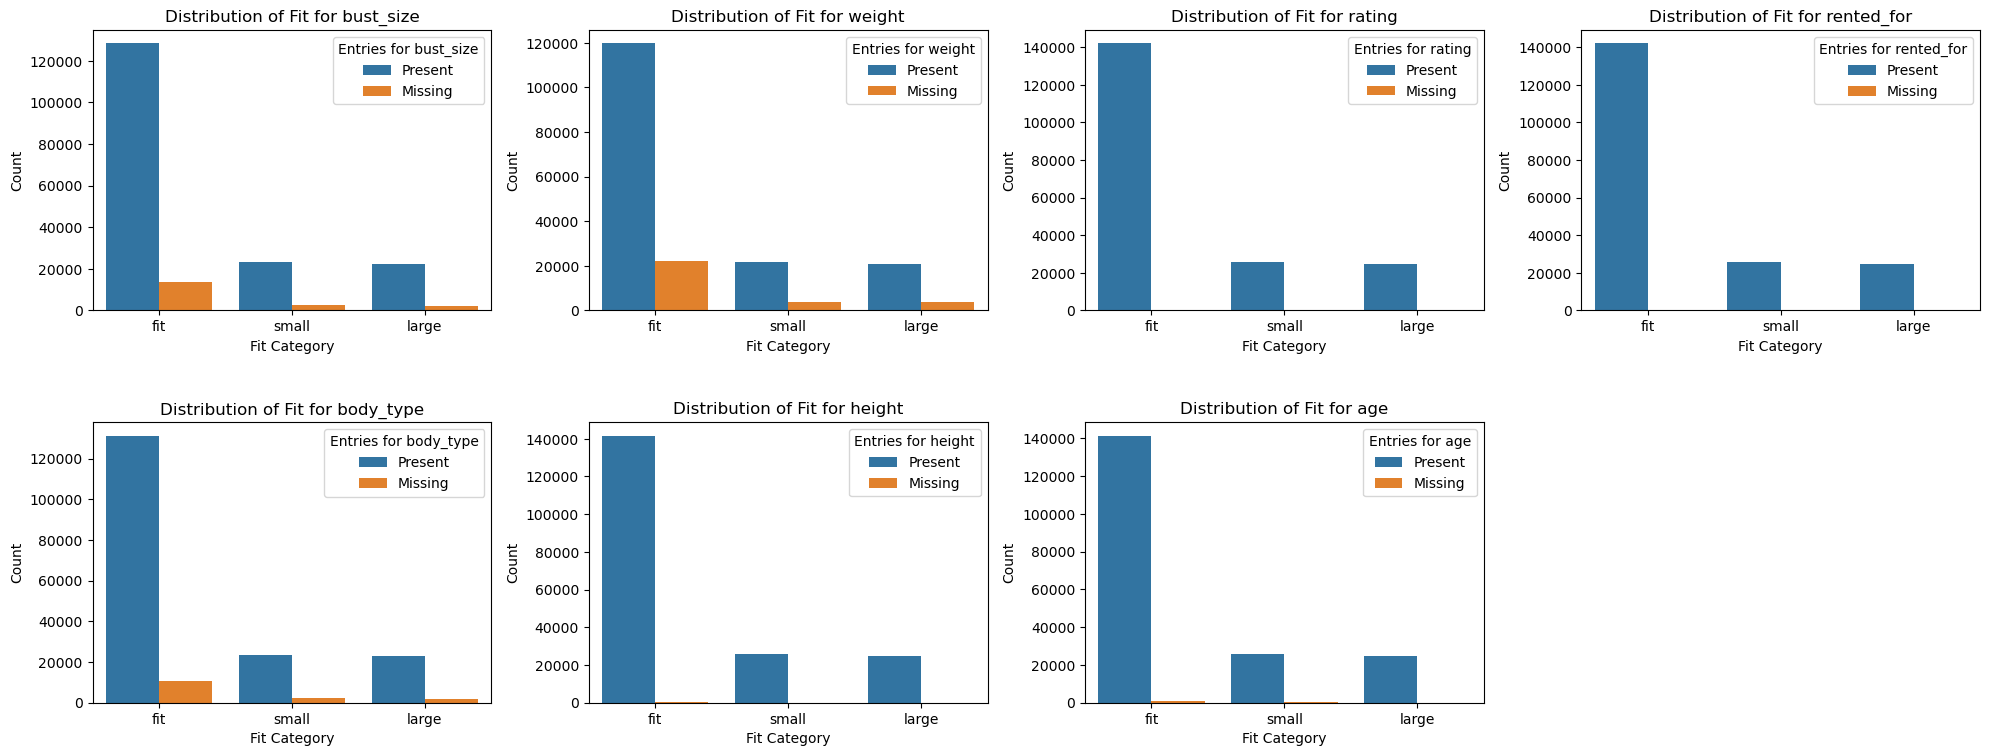

In [17]:
fig, axes = plt.subplots(3, 4, figsize=(20,12))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, feature in enumerate(features_with_na):
    data = dataset.copy()

    # Create a new column to indicate missing values
    data[f'{feature}_missing'] = np.where(data[feature].isnull(), 'Missing', 'Present')

    # Create the countplot
    sns.countplot(x='fit', hue=f'{feature}_missing', data=data, ax=axes[idx])

    axes[idx].set_title(f'Distribution of Fit for {feature}')
    axes[idx].set_xlabel('Fit Category')
    axes[idx].set_ylabel('Count')
    axes[idx].legend(title=f'Entries for {feature}', fontsize=10)
    # axes[idx].tick_params(axis='x', rotation=90)

# Remove any unused subplots
for idx in range(len(features_with_na), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

In [18]:
# list of numerical variables
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']

print('Number of numerical variables: ', len(numerical_features))

# visualise the numerical variables
dataset[numerical_features].head()

Number of numerical variables:  5


,user_id,item_id,rating,size,age
0,420272,2260466,10.0,14,28.0
1,273551,153475,10.0,12,36.0
2,360448,1063761,10.0,4,116.0
3,909926,126335,8.0,8,34.0
4,151944,616682,10.0,12,27.0


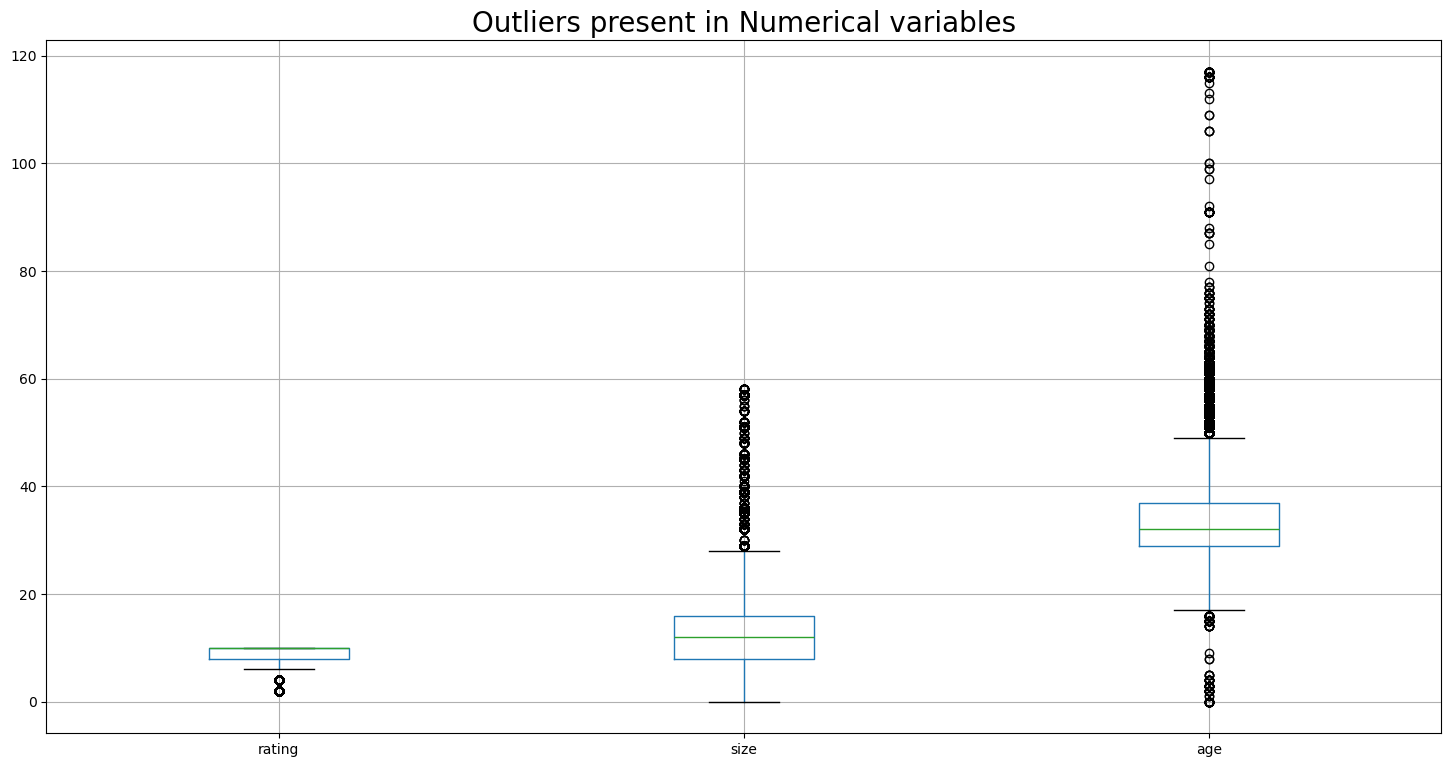

In [19]:
plt.figure(figsize=(18,9))
dataset[numerical_features].drop(['user_id','item_id'], axis=1).boxplot()
plt.title("Outliers present in Numerical variables", fontsize=20)
plt.show()

In [20]:
categorical_features=[feature for feature in dataset.columns if data[feature].dtypes=='O']
categorical_features

['fit',
 'bust_size',
 'weight',
 'rented_for',
 'review_text',
 'body_type',
 'review_summary',
 'category',
 'height',
 'review_date']

In [21]:
categorical_features.remove('review_date') #removing them as we don't need to clean these
categorical_features.remove('review_summary')
categorical_features.remove('review_text')

In [22]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature,len(dataset[feature].unique())))

The feature is fit and number of categories are 3
The feature is bust_size and number of categories are 107
The feature is weight and number of categories are 191
The feature is rented_for and number of categories are 10
The feature is body_type and number of categories are 8
The feature is category and number of categories are 68
The feature is height and number of categories are 25


C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\222172885.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[idx].legend(title='Fit', fontsize=8)
C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\222172885.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, ha='right')
C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\222172885.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, ha='right')
C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\222172885.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks()

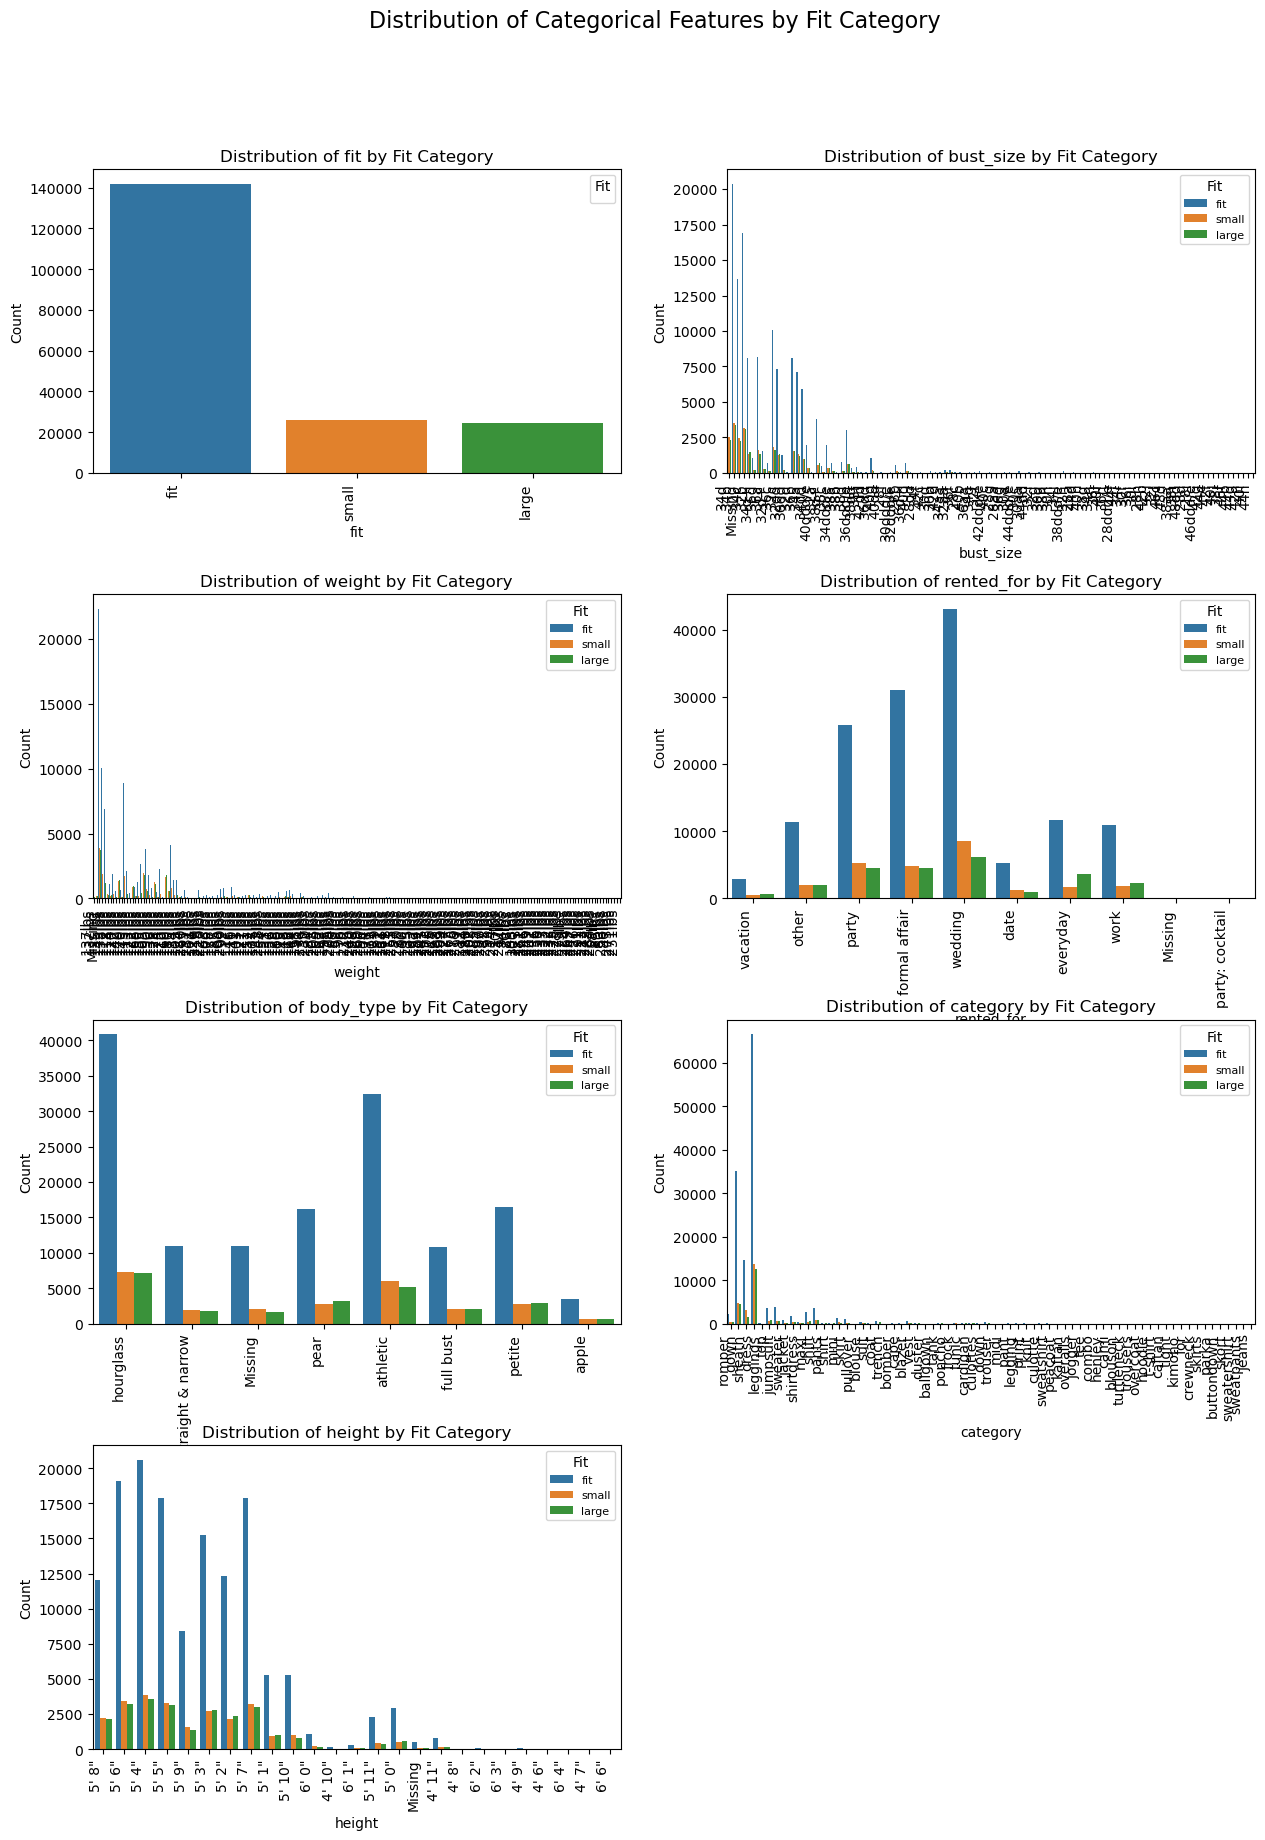

In [23]:
fig, axes = plt.subplots(4, 2, figsize=(15,20))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for idx, feature in enumerate(categorical_features):
    data = dataset.copy()

    # Handle missing values
    data[feature] = data[feature].fillna('Missing')

    # Create the countplot
    sns.countplot(x=feature, hue='fit', data=data, ax=axes[idx])

    axes[idx].set_title(f'Distribution of {feature} by Fit Category')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Count')
    axes[idx].legend(title='Fit', fontsize=8)

    # Rotate x-axis labels
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, ha='right')


# Remove any unused subplots
for idx in range(7, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Distribution of Categorical Features by Fit Category', fontsize=16)
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

We need to feature engineer 'Height' feature since it is in foot'inch'' format. We will convert it to centimeters.

In [24]:
def get_cms(x):
    if pd.isna(x):  # Handle NaN values
        return None
    try:
        # Split the height string by single quote
        feet = int(x.split("'")[0])
        # Get inches value between single quote and double quote
        inches = int(x.split("'")[1].strip('"'))
        return (feet * 30.48) + (inches * 2.54)
    except:
        return None

dataset.height = dataset.height.apply(get_cms)

In [25]:
dataset.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016"


Now let's find correlation between some features which we're interested in.

In [26]:
interested_features = ['fit', 'rating',
       'rented_for', 'body_type', 'category',
       'height', 'size', 'age', 'bust_size']
correlation_matrix = pd.get_dummies(dataset[interested_features]).corr()

We won't be printing heatmaps as we have many features and the heatmap would become cluttersome. Instead, we will make a correlation matrix and print the top 10 highest correlation pairs.

In [27]:
correlations = correlation_matrix.unstack()

# Step 2: Remove self-correlations (diagonal values)
correlations = correlations[correlations.index.get_level_values(0) != correlations.index.get_level_values(1)]

# Step 3: Sort by absolute value of correlation to get highest correlations
correlations_sorted = correlations.abs().sort_values(ascending=False)

# Step 4: Print top 15 correlations along with their corresponding row and column names
top_15 = correlations_sorted.head(15)
print(top_15)

fit_fit                   fit_small                   0.659520
fit_small                 fit_fit                     0.659520
fit_fit                   fit_large                   0.643596
fit_large                 fit_fit                     0.643596
category_dress            category_gown               0.528371
category_gown             category_dress              0.528371
                          rented_for_formal affair    0.499655
rented_for_formal affair  category_gown               0.499655
height                    body_type_petite            0.398845
body_type_petite          height                      0.398845
body_type_athletic        body_type_hourglass         0.343992
body_type_hourglass       body_type_athletic          0.343992
rented_for_wedding        rented_for_formal affair    0.337475
rented_for_formal affair  rented_for_wedding          0.337475
category_dress            category_sheath             0.322374
dtype: float64


In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented_for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  float64
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 22.0+ MB


We should convert weight into a numerical variable instead of categorical. Let's get all the unique values in weight.

In [29]:
print(dataset['weight'].dropna().unique())

['137lbs' '132lbs' '135lbs' '145lbs' '138lbs' '112lbs' '118lbs' '114lbs'
 '120lbs' '142lbs' '140lbs' '170lbs' '143lbs' '115lbs' '123lbs' '122lbs'
 '165lbs' '130lbs' '155lbs' '105lbs' '190lbs' '150lbs' '136lbs' '128lbs'
 '174lbs' '125lbs' '110lbs' '160lbs' '180lbs' '175lbs' '134lbs' '109lbs'
 '124lbs' '250lbs' '195lbs' '231lbs' '161lbs' '126lbs' '210lbs' '215lbs'
 '220lbs' '163lbs' '106lbs' '178lbs' '157lbs' '185lbs' '108lbs' '200lbs'
 '92lbs' '117lbs' '146lbs' '116lbs' '141lbs' '103lbs' '121lbs' '127lbs'
 '111lbs' '152lbs' '172lbs' '107lbs' '133lbs' '248lbs' '154lbs' '153lbs'
 '131lbs' '156lbs' '129lbs' '186lbs' '100lbs' '113lbs' '148lbs' '119lbs'
 '166lbs' '144lbs' '158lbs' '95lbs' '234lbs' '139lbs' '230lbs' '184lbs'
 '102lbs' '205lbs' '168lbs' '162lbs' '147lbs' '98lbs' '225lbs' '204lbs'
 '89lbs' '159lbs' '96lbs' '176lbs' '212lbs' '149lbs' '240lbs' '198lbs'
 '169lbs' '260lbs' '196lbs' '104lbs' '173lbs' '179lbs' '101lbs' '239lbs'
 '182lbs' '151lbs' '164lbs' '218lbs' '171lbs' '255lbs' '

Let's drop 'lbs' from all these values and convert it to numerical datatype.

In [30]:
dataset['weight'] = dataset['weight'].str.replace('lbs', '').astype(float)

In [31]:
dataset.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016"


Bust_size is made out of 2 things : Bra size and Cup size. We can divide it into these two features to better understand nuances of our model.

In [32]:
print(dataset['bust_size'].dropna().unique())

['34d' '34b' '34c' '32b' '34d+' '36d' '36a' '32d+' '36c' '32c' '32dd'
 '30dd' '32d' '36b' '34a' '34dd' '40ddd/e' '32a' '38d+' '38c' '34ddd/e'
 '38a' '38b' '38d' '36ddd/e' '38dd' '38f' '42dd' '36dd' '40g' '40dd' '28f'
 '30ddd/e' '32ddd/e' '28b' '36d+' '40d' '28dd' '34f' '42c' '30d' '30b'
 '42d' '34aa' '32aa' '36f' '28c' '40b' '36aa' '34g' '32f' '42ddd/e' '40c'
 '28g' '28aa' '36g' '30a' '44ddd/e' '30c' '30aa' '44dd' '32i' '32g' '30g'
 '38h' '30h' '34j' '38ddd/e' '32h' '28a' '44d' '40h' '38g' '34h' '36j'
 '40f' '36h' '28ddd/e' '44f' '34i' '30f' '36i' '30i' '28h' '42b' '42j'
 '32j' '46c' '48d' '38aa' '38i' '48dd' '28d' '28i' '46ddd/e' '42g' '44c'
 '42f' '40j' '38j' '46f' '44b' '44g' '42h' '40i' '44h']


First, we will extract cup size and then we will extract bra size from this feature. We will keep bra size as numerical and cup size as categorical.

In [33]:
dataset['bra_size'] = dataset['bust_size'].str.extract('(\d+)').astype(float)
dataset['cup_size'] = dataset['bust_size'].str.extract('([a-zA-Z]+)')

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\3027726909.py:1: SyntaxWarning: invalid escape sequence '\d'
  dataset['bra_size'] = dataset['bust_size'].str.extract('(\d+)').astype(float)


In [34]:
dataset.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,bra_size,cup_size
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016",34.0,d
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013",34.0,b
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015",NaN,NaN
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014",34.0,c
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016",34.0,b


In [35]:
print(dataset['bra_size'].dropna().unique())

[34. 32. 36. 30. 40. 38. 42. 28. 44. 46. 48.]


In [36]:
print(dataset['cup_size'].dropna().unique())

['d' 'b' 'c' 'a' 'dd' 'ddd' 'f' 'g' 'aa' 'i' 'h' 'j']


Now let's find out the missing values in remaining categorical variables. We will handle them now.

In [37]:
features_nan=[feature for feature in dataset.columns if dataset[feature].isnull().sum()>1 and dataset[feature].dtypes=='O']

for feature in features_nan:
    print("{}: {}% missing values".format(feature,np.round(dataset[feature].isnull().mean(),4)))

bust_size: 0.0956% missing values
rented_for: 0.0001% missing values
body_type: 0.076% missing values
cup_size: 0.0956% missing values


We will replace these missing categorical values with text "Missing"

In [38]:
## Replace missing value with a new label
def replace_cat_feature(dataset,features_nan):
    data=dataset.copy()
    data[features_nan]=data[features_nan].fillna('Missing')
    return data

dataset=replace_cat_feature(dataset,features_nan)

dataset[features_nan].isnull().sum()

bust_size     0
rented_for    0
body_type     0
cup_size      0
dtype: int64

In [39]:
dataset.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,bra_size,cup_size
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016",34.0,d
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013",34.0,b
2,fit,360448,Missing,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,Missing,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015",NaN,Missing
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014",34.0,c
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016",34.0,b


Now, let's get all the numerical values with missing values and handle them.

In [40]:
## Now lets check for numerical variables the contains missing values
numerical_with_nan=[feature for feature in dataset.columns if dataset[feature].isnull().sum()>1 and dataset[feature].dtypes!='O']

## We will print the numerical nan variables and percentage of missing values

for feature in numerical_with_nan:
    print("{}: {}% missing value".format(feature,np.around(dataset[feature].isnull().mean(),4)))

weight: 0.1557% missing value
rating: 0.0004% missing value
height: 0.0035% missing value
age: 0.005% missing value
bra_size: 0.0956% missing value


We fill these missing values with avg.

In [41]:
for feature in numerical_with_nan:
    ## We will replace by using median since there are outliers
    median_value=dataset[feature].median()

    ## create a new feature to capture nan values
    dataset[feature+'nan']=np.where(dataset[feature].isnull(),1,0)
    dataset[feature].fillna(median_value,inplace=True)

dataset[numerical_with_nan].isnull().sum()

C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\2875223130.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset[feature].fillna(median_value,inplace=True)
C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\2875223130.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

weight      0
rating      0
height      0
age         0
bra_size    0
dtype: int64

In [42]:
dataset.head(20)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,bra_size,cup_size,weightnan,ratingnan,heightnan,agenan,bra_sizenan
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016",34.0,d,0,0,0,0,0
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013",34.0,b,0,0,0,0,0
2,fit,360448,Missing,1063761,135.0,10.0,party,This hugged in all the right places! It was a ...,Missing,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015",34.0,Missing,1,0,0,0,1
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014",34.0,c,0,0,0,0,0
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016",34.0,b,0,0,0,0,0
5,fit,734848,32b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,172.72,8,45.0,"April 30, 2016",32.0,b,0,0,0,0,0
6,fit,336066,34c,568429,112.0,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,160.02,4,27.0,"December 7, 2017",34.0,c,0,0,0,0,0
7,fit,86661,34d+,130259,118.0,10.0,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,160.02,8,65.0,"January 1, 2013",34.0,d,0,0,0,0,0
8,fit,166228,36d,1729232,135.0,10.0,formal affair,I was nervous of it looking cheap when it arri...,full bust,Great for black tie event!,gown,167.64,21,27.0,"June 27, 2016",36.0,d,1,0,0,0,0
9,fit,154309,32b,1729232,114.0,10.0,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,160.02,1,33.0,"October 17, 2016",32.0,b,0,0,0,0,0


In [43]:
print(dataset.shape)

(192544, 22)


In [44]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust_size       192544 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          192544 non-null  float64
 5   rating          192544 non-null  float64
 6   rented_for      192544 non-null  object 
 7   review_text     192544 non-null  object 
 8   body_type       192544 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          192544 non-null  float64
 12  size            192544 non-null  int64  
 13  age             192544 non-null  float64
 14  review_date     192544 non-null  object 
 15  bra_size        192544 non-null  float64
 16  cup_size        192544 non-null  object 
 17  weightnan 

# Sentiment Analysis:

In [45]:
# Define dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

In [46]:
# Tokenizer and model initialization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-SST-2")

In [47]:
# Ensure all values in 'review_text' are strings and drop invalid rows
dataset["review_text"] = dataset["review_text"].astype(str).str.strip()
dataset = dataset[dataset["review_text"] != ""]  # Remove rows with empty strings

# Limit rows for testing
# dataset = dataset.sample(n=1000, random_state=42).reset_index(drop=True)

# Prepare the dataset
texts = dataset["review_text"].tolist()
review_df = ReviewDataset(texts, tokenizer)
dataloader = DataLoader(review_df, batch_size=32)

In [48]:
# Define keywords and their weights
positive_keywords = [
    'great', 'perfect', 'loved', 'comfortable', 'compliments', 'fantastic', 'excellent', 'beautiful', 'flattering',
    'love', 'perfectly', 'nice', 'cute', 'good', 'gorgeous', 'amazing', 'liked', 'fine', 'loved dress', 'fit perfectly',
    'received compliments', 'got compliments', 'dress fit', 'great dress', 'dress perfect', 'dress beautiful',
    'compliments night', 'beautiful dress', 'highly recommend', 'lots compliments', 'form fitting', 'fit perfect', 'fun',
    'sexy', 'worked', 'snug', 'tailored', 'sleek', 'elegant', 'chic', 'stylish', 'form-fitting', 'seamless', 'cozy', 'luxurious',
    'well-made', 'high-quality', 'durable', 'breathable', 'soft', 'supple', 'flexible', 'adaptable', 'polished', 'refined',
    'trendy', 'modern', 'classic', 'sophisticated', 'smart', 'neat', 'trim', 'crisp', 'fitted', 'customized', 'bespoke',
    'adjustable', 'supportive', 'lightweight', 'airy', 'smooth', 'silky', 'plush', 'resilient', 'robust', 'sturdy', 'reliable',
    'dependable', 'practical', 'functional', 'effortless', 'easy-to-wear', 'tailored to perfection', 'fits like a dream',
    'like a second skin', 'ultimate relaxation', 'moves with you', 'perfectly cozy'
]

negative_keywords = [
    'little', 'small', 'tight', 'didnt', 'runs', 'big', 'long', 'back', 'short', 'waist', 'chest', 'wasnt', 'hips',
    'backup', 'smaller', 'bigger', 'cut', 'loose', 'larger', 'sizing', 'runs small', 'little big', 'runs large', 'little tight',
    'ordered size', 'little large', 'size size', 'backup size', 'definitely runs', 'bit large', 'recommend sizing',
    'dress ran', 'bit small', 'fit little', 'bit big', 'larger size', 'fashion tape', 'bust area',
    'rib cage', 'runsmall', 'run big', 'runs bit', 'dress runs small', 'size smaller', 'size bigger', 'size backup',
    'little short', 'dress tight', 'tight dress', 'however', 'unfortunately', 'wouldnt', 'ended wearing', 'end wearing', 'just didnt',
    'didn wear', 'wasn flattering', 'wouldn rent', 'didn love', 'unable wear', 'ran small', 'ran big', 'customer service',
    'self conscious', 'terrible', 'poor', 'bad', 'uncomfortable', 'horrible', 'ill-fitting', 'tight', 'loose', 'awkward',
    'restrictive', 'baggy', 'saggy', 'misfitting', 'oversized', 'undersized', 'constricting', 'sloppy', 'shapeless', 'unflattering',
    'bulky', 'droopy', 'hanging', 'tent-like', 'billowy', 'too big', 'too loose', 'too tight', 'pinching', 'squeezing', 'binding',
    'unbreathable', 'cramped', 'stiff', 'immobile', 'itchy', 'scratchy', 'irritating', 'unbearable', 'discomfort', 'annoying',
    'displeasing', 'disappointing', 'unsatisfactory', 'dissatisfied', 'unappealing', 'unattractive', 'unpleasant', 'embarrassing',
    'self-conscious', 'awkward', 'distressing', 'disheartening', 'off-putting', 'exasperating'
]

# Define weights for keyword occurrences and review length
keyword_weight = 2   # Weight added for each keyword occurrence
length_factor = 0.025   # Weight for review length

In [49]:
# Modify the prediction function
def predict_sentiments(dataloader, model, df):
    model.eval()
    logits_list = []
    predictions = []

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]

            # Get BERT logits
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()

            # Adjust logits based on keywords and review length
            for i, logit in enumerate(logits):
                review = df.iloc[idx * 32 + i]["review_text"].lower()  # Get the corresponding review
                length = len(review.split())  # Review length in words

                # Keyword adjustment
                pos_count = sum(review.count(word) for word in positive_keywords)
                neg_count = sum(review.count(word) for word in negative_keywords)

                logit[1] += pos_count * keyword_weight  # Boost positive class logit
                logit[0] += neg_count * keyword_weight  # Boost negative class logit

                # Length adjustment
                adjustment = length * length_factor
                logit += adjustment if logit[1] > logit[0] else -adjustment  # Amplify dominant sentiment

                logits_list.append(logit)
                predictions.append(np.argmax(logit))  # Classify based on adjusted logits

    return logits_list, predictions

In [50]:
# Run predictions
logits_list, numerical_sentiments = predict_sentiments(
    dataloader, model, dataset
)
# Add results to DataFrame
dataset["logits"] = [logit.tolist() for logit in logits_list]  # Convert logits to a list
dataset["numerical_sentiment"] = numerical_sentiments  # Add numerical sentiment

In [51]:
dataset.head(10)

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,bra_size,cup_size,weightnan,ratingnan,heightnan,agenan,bra_sizenan,logits,numerical_sentiment
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016",34.0,d,0,0,0,0,0,"[-0.41091954708099365, 8.210256576538086]",1
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013",34.0,b,0,0,0,0,0,"[0.7078686952590942, 7.170872211456299]",1
2,fit,360448,Missing,1063761,135.0,10.0,party,This hugged in all the right places! It was a ...,Missing,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015",34.0,Missing,1,0,0,0,1,"[-0.7814234495162964, 10.632160186767578]",1
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014",34.0,c,0,0,0,0,0,"[4.578804016113281, 13.363463401794434]",1
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016",34.0,b,0,0,0,0,0,"[8.343437194824219, -1.8913849592208862]",0
5,fit,734848,32b,364092,138.0,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,172.72,8,45.0,"April 30, 2016",32.0,b,0,0,0,0,0,"[0.052380383014678955, 15.533520698547363]",1
6,fit,336066,34c,568429,112.0,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,160.02,4,27.0,"December 7, 2017",34.0,c,0,0,0,0,0,"[3.437988758087158, 7.908382415771484]",1
7,fit,86661,34d+,130259,118.0,10.0,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,160.02,8,65.0,"January 1, 2013",34.0,d,0,0,0,0,0,"[5.102080345153809, 3.9955883026123047]",0
8,fit,166228,36d,1729232,135.0,10.0,formal affair,I was nervous of it looking cheap when it arri...,full bust,Great for black tie event!,gown,167.64,21,27.0,"June 27, 2016",36.0,d,1,0,0,0,0,"[-1.5998213291168213, 8.43028450012207]",1
9,fit,154309,32b,1729232,114.0,10.0,formal affair,The dress was very flattering and fit perfectl...,petite,This dress was everything! It was perfect for ...,gown,160.02,1,33.0,"October 17, 2016",32.0,b,0,0,0,0,0,"[8.307838439941406, 26.590681076049805]",1


In [52]:
# Calculate the average rating
average_rating = dataset["rating"].mean()

# Create the 'true_sentiment' column
dataset["true_sentiment"] = dataset["rating"].apply(lambda x: 1 if x > average_rating else 0)

# Assuming you have ground truth labels in a column 'true_sentiment'
# 1 for positive and 0 for negative
true_sentiments = dataset["true_sentiment"].tolist()
predicted_sentiments = dataset["numerical_sentiment"].tolist()

# Calculate metrics
accuracy = accuracy_score(true_sentiments, predicted_sentiments)
precision = precision_score(true_sentiments, predicted_sentiments)
recall = recall_score(true_sentiments, predicted_sentiments)
f1 = f1_score(true_sentiments, predicted_sentiments)

# Print metrics
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Classification report for detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(true_sentiments, predicted_sentiments, target_names=["Negative", "Positive"]))

Performance Metrics:
Accuracy: 0.70
Precision: 0.74
Recall: 0.83
F1-Score: 0.78

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.60      0.46      0.52     67923
    Positive       0.74      0.83      0.78    124619

    accuracy                           0.70    192542
   macro avg       0.67      0.65      0.65    192542
weighted avg       0.69      0.70      0.69    192542



In [53]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 192542 entries, 0 to 192543
Data columns (total 25 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   fit                  192542 non-null  object 
 1   user_id              192542 non-null  int64  
 2   bust_size            192542 non-null  object 
 3   item_id              192542 non-null  int64  
 4   weight               192542 non-null  float64
 5   rating               192542 non-null  float64
 6   rented_for           192542 non-null  object 
 7   review_text          192542 non-null  object 
 8   body_type            192542 non-null  object 
 9   review_summary       192542 non-null  object 
 10  category             192542 non-null  object 
 11  height               192542 non-null  float64
 12  size                 192542 non-null  int64  
 13  age                  192542 non-null  float64
 14  review_date          192542 non-null  object 
 15  bra_size             1

In [106]:
!jupyter nbconvert --clear-output --to html --output "D:/Renttherunway_GRASP/SA.html" D:/Renttherunway_GRASP/Renttherunway_rec_system.ipynb

[NbConvertApp] Converting notebook D:/Renttherunway_GRASP/Renttherunway_rec_system.ipynb to notebook
[NbConvertApp] Writing 131254 bytes to D:\Renttherunway_GRASP\SA.html.ipynb


In [54]:
# Combine all reviews into a single string
text = ' '.join(dataset['review_text'])
# Create and generate a word cloud image
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=100,
    collocations=False
).generate(text)

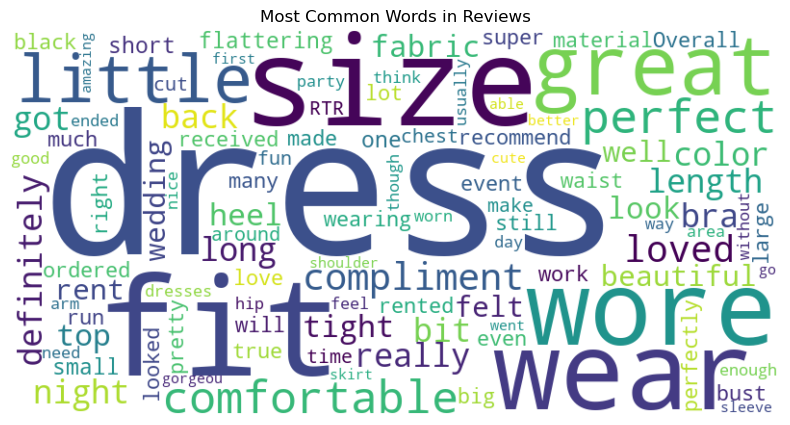

In [55]:
# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()

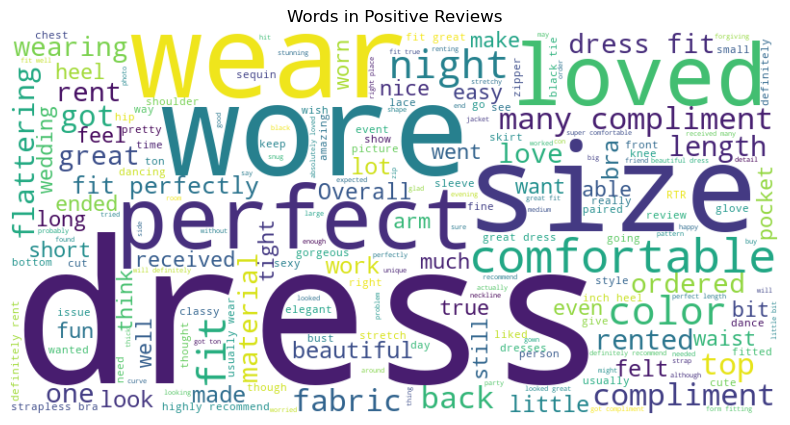

In [56]:
# Optional: Create separate word clouds for positive and negative reviews
pos_reviews = ' '.join(dataset[dataset['numerical_sentiment'] == 1]['review_text'])
neg_reviews = ' '.join(dataset[dataset['numerical_sentiment'] == 0]['review_text'])

# Positive reviews word cloud
pos_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pos_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words in Positive Reviews')
plt.show()

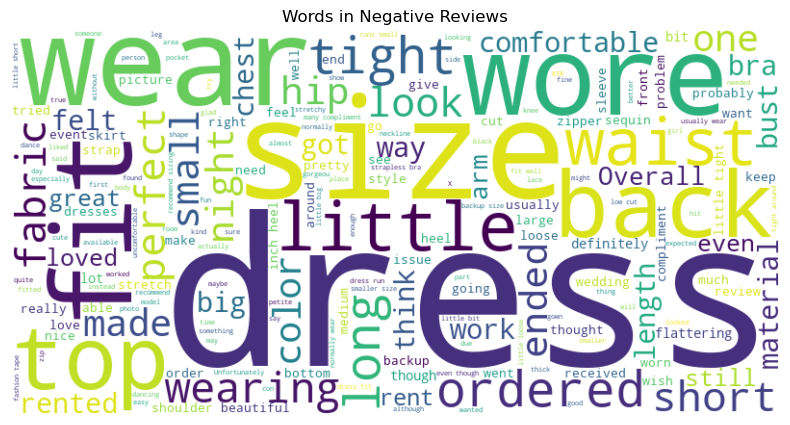

In [57]:
# Negative reviews word cloud
neg_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neg_reviews)
plt.figure(figsize=(10, 5))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Words in Negative Reviews')
plt.show()

In [58]:
# For positive reviews
positive_reviews = dataset[dataset['numerical_sentiment'] == 1]
avg_positive_rating = positive_reviews['rating'].mean()

# For negative reviews
negative_reviews = dataset[dataset['numerical_sentiment'] == 0]
avg_negative_rating = negative_reviews['rating'].mean()

print(f"Average rating for positive reviews: {avg_positive_rating:.2f}")
print(f"Average rating for negative reviews: {avg_negative_rating:.2f}")

Average rating for positive reviews: 9.42
Average rating for negative reviews: 8.22


In [8]:
dataset = pd.read_csv(r'D:\Renttherunway_GRASP\my_dataset.csv')

# Content Based Recommendation:

In [9]:
# Selecting the relevant features for recommendation
selected_features = ['weight','height','size','age','bra_size','rented_for','body_type','category','cup_size','fit','numerical_sentiment']
selected_features

['weight',
 'height',
 'size',
 'age',
 'bra_size',
 'rented_for',
 'body_type',
 'category',
 'cup_size',
 'fit',
 'numerical_sentiment']

In [10]:
scaler = StandardScaler()

dataset['weight_scaled'] = scaler.fit_transform(dataset[['weight']])
dataset['height_scaled'] = scaler.fit_transform(dataset[['height']])
dataset['size_scaled'] = scaler.fit_transform(dataset[['size']])
dataset['age_scaled'] = scaler.fit_transform(dataset[['age']])
dataset['bra_size_scaled'] = scaler.fit_transform(dataset[['bra_size']])
dataset['sentiment_scaled'] = scaler.fit_transform(dataset[['numerical_sentiment']])

In [11]:
le_rented_for = LabelEncoder()
le_body_type = LabelEncoder()
le_category = LabelEncoder()
le_cup_size = LabelEncoder()
le_fit = LabelEncoder()

# Create encoded soup
dataset['encoded_soup'] = (dataset['weight_scaled'].astype(str) + ' ' +
                     dataset['height_scaled'].astype(str) + ' ' +
                     dataset['size_scaled'].astype(str) + ' ' +
                     dataset['age_scaled'].astype(str) + ' ' +
                     dataset['bra_size_scaled'].astype(str) + ' ' +
                     dataset['sentiment_scaled'].astype(str) + ' ' +
                     le_cup_size.fit_transform(dataset['cup_size']).astype(str) + ' ' +
                     le_rented_for.fit_transform(dataset['rented_for']).astype(str) + ' ' +
                     le_body_type.fit_transform(dataset['body_type']).astype(str) + ' ' +
                     le_fit.fit_transform(dataset['fit']).astype(str) + ' ' +
                     le_category.fit_transform(dataset['category']).astype(str))

In [12]:
dataset['encoded_soup']

0         -0.000943037226767845 1.0118911519211746 0.206...
1         -0.24919881206452799 0.2596893637111984 -0.028...
2         -0.1002453471618719 -0.49251242449877364 -0.97...
3         -0.1002453471618719 -0.11641153039378763 -0.49...
4         0.39626620251364836 1.3879920460261608 -0.0288...
                                ...                        
192537    0.14801042767588823 1.3879920460261608 -0.4997...
192538    -1.838035771026193 -1.620815106813736 -0.97062...
192539    -0.1002453471618719 1.0118911519211746 -0.4997...
192540    1.389289301864689 0.2596893637111984 0.4420002...
192541    0.8927777521891687 0.2596893637111984 0.442000...
Name: encoded_soup, Length: 192542, dtype: object

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(dataset['encoded_soup'])
tfidf_matrix.shape

(192542, 5489)

In [43]:
# # Function that takes in movie title as input and outputs most similar movies
# def get_recommendations_cos(title, cosine_sim=cosine_sim):
#     # Get the index of the movie that matches the title
#     idx = indices[title]

#     # Get the pairwsie similarity scores of all movies with that movie
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the movies based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar movies
#     sim_scores = sim_scores[1:11]

#     # Get the movie indices
#     movie_indices = [i[0] for i in sim_scores]

#     # Return the top 10 most similar movies
#     return df2['title'].iloc[movie_indices]

In [44]:
# similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [45]:
# def get_top_k_similarities_cos(tfidf_matrix, k=10, chunk_size=10):
#     n_samples = tfidf_matrix.shape[0]
#     top_similarities = {}

#     for i in range(0, n_samples, chunk_size):
#         end = min(i + chunk_size, n_samples)
#         # Process one row at a time
#         chunk_similarities = cosine_similarity(
#             tfidf_matrix[i:end],
#             tfidf_matrix,
#             dense_output=False
#         )

#         for idx, sims in enumerate(chunk_similarities):
#             actual_idx = i + idx
#             # Get only top k similar items
#             top_k_indices = np.argpartition(sims.toarray()[0], -k)[-k:]
#             top_similarities[actual_idx] = {
#                 'indices': top_k_indices,
#                 'scores': sims.toarray()[0][top_k_indices]
#             }

#         # Clear memory
#         del chunk_similarities

#     return top_similarities

In [46]:
# get_top_k_similarities_cos(tfidf_matrix)

In [14]:
def build_annoy_index(tfidf_matrix, n_trees=100):
    n_features = tfidf_matrix.shape[1]
    annoy_index = AnnoyIndex(n_features, 'angular')

    for i in range(tfidf_matrix.shape[0]):
        vector = tfidf_matrix[i].toarray()[0]
        annoy_index.add_item(i, vector)

    annoy_index.build(n_trees)
    return annoy_index

In [15]:
def get_recommendations(annoy_index, item_id, n_recommendations=10):
    # First get the index position of the item_id in the dataset
    item_idx = dataset[dataset['item_id'] == item_id].index[0]

    # Get the n nearest neighbors using the index position
    similar_indices = annoy_index.get_nns_by_item(item_idx, n_recommendations + 1)

    # Remove the query item itself (first item)
    similar_indices = similar_indices[1:]

    # Get the corresponding items with selected columns
    recommended_items = dataset.loc[similar_indices, ['item_id', 'rented_for', 'body_type', 'category','rating']]

    return recommended_items

In [16]:
annoy_index = build_annoy_index(tfidf_matrix)

In [17]:
get_recommendations(annoy_index, 2260466)

,item_id,rented_for,body_type,category,rating
16494,1083818,vacation,hourglass,dress,10.0
176650,536347,wedding,athletic,dress,10.0
135117,2431951,vacation,hourglass,jumpsuit,6.0
86500,2008057,everyday,athletic,jacket,10.0
42588,2340996,everyday,hourglass,jumpsuit,2.0
106996,2834619,everyday,athletic,jacket,10.0
1496,2771463,vacation,pear,romper,10.0
17328,1600987,everyday,pear,dress,10.0
33591,1031440,party,hourglass,dress,10.0
52220,247125,party,pear,dress,10.0


In [68]:
rmse_scores = []
mae_scores = []
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [69]:
def training_loop(dataset, tfidf):
    item_to_idx = {}
    train_tfidf_matrix = None

    for train_idx, test_idx in k_folds.split(dataset):
        # Split data
        train_data = dataset.iloc[train_idx]
        test_data = dataset.iloc[test_idx]

        train_tfidf_matrix = tfidf.fit_transform(train_data['encoded_soup'])

        # Build Annoy index
        annoy_index = build_annoy_index(train_tfidf_matrix)

        item_to_idx.update({item_id: idx for idx, item_id in enumerate(train_data['item_id'])})

    return train_tfidf_matrix, item_to_idx, annoy_index

In [70]:
def testing_function(test_data, annoy_index, item_to_idx, train_data):
    y_true_rating = []
    y_pred_rating = []

    for _, test_item in test_data.iterrows():
        if test_item['item_id'] in item_to_idx:
            # Get the correct index for the item
            item_idx = item_to_idx[test_item['item_id']]

            # Get similar items
            similar_indices = annoy_index.get_nns_by_item(item_idx, 5)
            similar_items = train_data.iloc[similar_indices]

            # Predict rating and fit
            pred_rating = similar_items['rating'].mean()
            y_true_rating.append(test_item['rating'])
            y_pred_rating.append(pred_rating)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true_rating, y_pred_rating))
    mae = mean_absolute_error(y_true_rating, y_pred_rating)

    return rmse, mae

In [71]:
# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(k_folds.split(dataset), 1):
    # Split data
    train_data = dataset.iloc[train_idx]
    test_data = dataset.iloc[test_idx]

    train_tfidf_matrix, item_to_idx, annoy_index = training_loop(train_data, tfidf)
    fold_rmse, fold_mae = testing_function(test_data, annoy_index, item_to_idx, train_data)

    # Print results for this fold
    print(f"Fold {fold}:")
    print(f"RMSE: {fold_rmse:.4f}")
    print(f"MAE: {fold_mae:.4f}")
    print()

    # Append only the last score for this fold
    rmse_scores.append(fold_rmse)
    mae_scores.append(fold_mae)

Fold 1:
RMSE: 1.5580
MAE: 1.1801

Fold 2:
RMSE: 1.5458
MAE: 1.1842

Fold 3:
RMSE: 1.5864
MAE: 1.2025

Fold 4:
RMSE: 1.5546
MAE: 1.1762

Fold 5:
RMSE: 1.5485
MAE: 1.1778



In [72]:
len(rmse_scores)

5

In [ ]:
# # Calculate average scores
# avg_rmse = sum(rmse_scores) / len(rmse_scores)
# avg_mae = sum(mae_scores) / len(mae_scores)

# print(f"Average RMSE: {avg_rmse:.4f}")
# print(f"Average MAE: {avg_mae:.4f}")

In [73]:
# Print results
print("Average RMSE:", np.mean(rmse_scores))
print("Average MAE:", np.mean(mae_scores))

Average RMSE: 1.5586470139294633
Average MAE: 1.1841347655325727


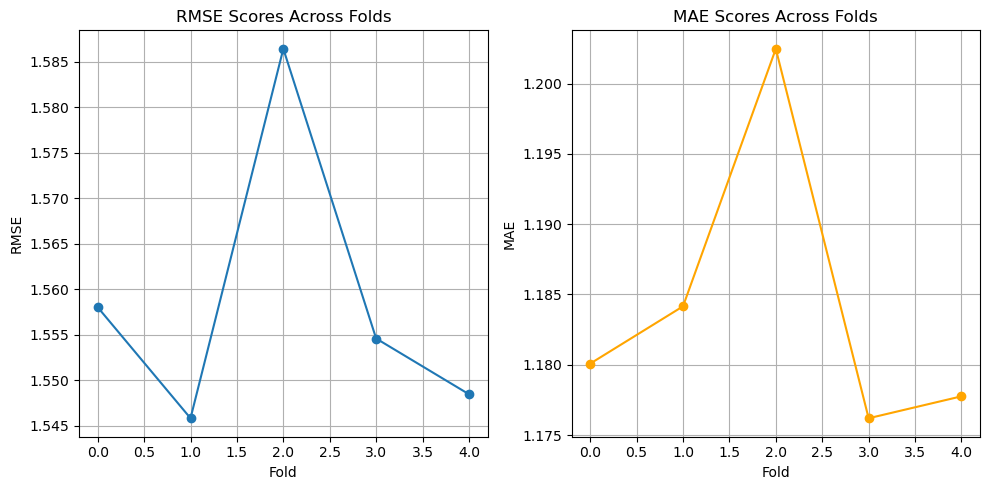

In [74]:
# Plot training loss across folds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(rmse_scores, marker='o')
plt.title('RMSE Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mae_scores, marker='o', color='orange')
plt.title('MAE Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
dataset.to_csv('D:\Renttherunway_GRASP\my_dataset.csv', index=False)

<>:1: SyntaxWarning: invalid escape sequence '\R'
<>:1: SyntaxWarning: invalid escape sequence '\R'
C:\Users\kisha\AppData\Local\Temp\ipykernel_2200\1285683778.py:1: SyntaxWarning: invalid escape sequence '\R'
  dataset.to_csv('D:\Renttherunway_GRASP\my_dataset.csv', index=False)


In [76]:
dataset.head()

,fit,user_id,bust_size,item_id,weight,rating,rented_for,review_text,body_type,review_summary,category,height,size,age,review_date,bra_size,cup_size,weightnan,ratingnan,heightnan,agenan,bra_sizenan,logits,numerical_sentiment,true_sentiment,weight_scaled,height_scaled,size_scaled,age_scaled,bra_size_scaled,sentiment_scaled,encoded_soup
0,fit,420272,34d,2260466,137.0,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,172.72,14,28.0,"April 20, 2016",34.0,d,0,0,0,0,0,"[-0.41091954708099365, 8.210256576538086]",1,1,-0.000943,1.011891,0.206563,-0.729156,-0.109605,0.609900,-0.000943037226767845 1.0118911519211702 0.206...
1,fit,273551,34b,153475,132.0,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,167.64,12,36.0,"June 18, 2013",34.0,b,0,0,0,0,0,"[0.7078686952590942, 7.170872211456299]",1,1,-0.249199,0.259689,-0.028874,0.265986,-0.109605,0.609900,-0.24919881206452799 0.25968936371119833 -0.02...
2,fit,360448,Missing,1063761,135.0,10.0,party,This hugged in all the right places! It was a ...,Missing,It was a great time to celebrate the (almost) ...,sheath,162.56,4,116.0,"December 14, 2015",34.0,Missing,1,0,0,0,1,"[-0.7814234495162964, 10.632160186767578]",1,1,-0.100245,-0.492512,-0.970623,10.217411,-0.109605,0.609900,-0.1002453471618719 -0.49251242449877775 -0.97...
3,fit,909926,34c,126335,135.0,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,165.10,8,34.0,"February 12, 2014",34.0,c,0,0,0,0,0,"[4.578804016113281, 13.363463401794434]",1,0,-0.100245,-0.116412,-0.499749,0.017201,-0.109605,0.609900,-0.1002453471618719 -0.1164115303937918 -0.499...
4,fit,151944,34b,616682,145.0,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,175.26,12,27.0,"September 26, 2016",34.0,b,0,0,0,0,0,"[8.343437194824219, -1.8913849592208862]",0,1,0.396266,1.387992,-0.028874,-0.853549,-0.109605,-1.639613,0.39626620251364836 1.3879920460261561 -0.0288...


In [78]:
# Convert logits directly to numpy array
logits_array = np.array(dataset['logits'].tolist())
positive_logits = logits_array[:, 1]  # Positive sentiment logits
negative_logits = logits_array[:, 0]  # Negative sentiment logits
# Calculate sentiment scores (0-10 scale)
sentiment_scores = (positive_logits - negative_logits + 1) * 5  # Normalize to 0-10 scale

In [79]:
# Calculate NPS
def calculate_nps(scores):
    promoters = np.sum(scores >= 9)
    detractors = np.sum(scores <= 6)
    total = len(scores)
    nps = ((promoters/total) - (detractors/total)) * 100
    return nps

# Calculate CSAT
def calculate_csat(scores):
    satisfied = np.sum(scores >= 7)
    total = len(scores)
    csat = (satisfied/total) * 100
    return csat

In [80]:
# Add scores to dataset
dataset['sentiment_score'] = sentiment_scores
dataset['nps_category'] = pd.cut(sentiment_scores,
                                bins=[-np.inf, 6, 8, np.inf],
                                labels=['Detractor', 'Passive', 'Promoter'])

# Calculate and print metrics
nps = calculate_nps(sentiment_scores)
csat = calculate_csat(sentiment_scores)

In [81]:
print(f"Net Promoter Score (NPS): {nps:.2f}")
print(f"Customer Satisfaction Score (CSAT): {csat:.2f}%")

# Optional: Distribution analysis
nps_distribution = dataset['nps_category'].value_counts(normalize=True) * 100
print("\nNPS Distribution:")
print(nps_distribution)

Net Promoter Score (NPS): 42.70
Customer Satisfaction Score (CSAT): 71.64%

NPS Distribution:
nps_category
Promoter     71.056185
Detractor    27.748232
Passive       1.195583
Name: proportion, dtype: float64


In [ ]:
dataset['user_id']

0         420272
1         273551
2         360448
3         909926
4         151944
           ...  
192539     66386
192540    118398
192541     47002
192542    961120
192543    123612
Name: user_id, Length: 192544, dtype: int64

# Neural Graph Collaborative Filtering:

In [32]:
class NGCFLayer(MessagePassing):
    def __init__(self, in_size, out_size, dropout=0.1):
        super().__init__(aggr='add')
        self.W1 = nn.Linear(in_size, out_size)
        self.W2 = nn.Linear(in_size, out_size)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(dropout) #Randomly "drops out" a portion of neurons during training. Encourages the model to learn more robust features. Particularly important in graphs, where overfitting to specific paths can be an issue.

    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(row)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        out = self.propagate(edge_index, x=x, norm=norm)
        out = self.dropout(out)
        return self.leaky_relu(out + x)  # Apply activation after residual

    def message(self, x_j, norm):
        x_j = self.dropout(x_j)
        transformed = self.W1(x_j) + self.W2(x_j)
        return norm.view(-1, 1) * transformed

In [33]:
class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_size=64):
        super().__init__()

        # Embeddings
        self.n_users = n_users
        self.n_items = n_items
        self.user_embedding = nn.Embedding(n_users, emb_size)
        self.item_embedding = nn.Embedding(n_items, emb_size)

        # NGCF layers
        self.layers = nn.ModuleList([
            NGCFLayer(emb_size, emb_size),
            NGCFLayer(emb_size, emb_size),
            NGCFLayer(emb_size, emb_size)
        ])

        # Prediction layers
        self.predictor = nn.Sequential(
            nn.Linear(emb_size*2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # 2 outputs for rating and fit
        )

        self.init_weights()

    def init_weights(self):
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)

    def forward(self, user_nodes, item_nodes, edge_index):
        # Get embeddings
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        x = torch.cat([user_emb, item_emb])

        # Message passing
        all_embeddings = [x]
        for layer in self.layers:
            x = layer(x, edge_index) #Applies the current layer in loop to the embeddings x and the graph structure edge_index. This is where the actual message passing occurs, updating node embeddings based on their neighbors.
            x = F.normalize(x) #Normalizes the embeddings after each layer. This helps stabilize training and prevents exploding gradients.
            all_embeddings.append(x)

        x = torch.stack(all_embeddings, dim=1)
        x = torch.mean(x, dim=1)

        # Split users and items
        users_emb = x[:self.n_users]
        items_emb = x[self.n_users:]

        # Get specific embeddings for prediction
        user_emb = users_emb[user_nodes]
        item_emb = items_emb[item_nodes]

        # Predict both rating and fit
        concat = torch.cat([user_emb, item_emb], dim=1)
        pred = self.predictor(concat)
        rating_pred = torch.sigmoid(pred[:, 0]) * 10.0  # Scale to 1-10 rating
       # fit_pred = F.softmax(pred[:, 1].unsqueeze(-1), dim=1)  # Fit prediction

        return rating_pred

In [34]:
# Initialize encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# Encode IDs
encoded_user_ids = user_encoder.fit_transform(dataset['user_id'])
encoded_item_ids = item_encoder.fit_transform(dataset['item_id'])

In [35]:
# First get user and item IDs from dataset
user_ids = dataset['user_id'].values
item_ids = dataset['item_id'].values

# Create edge index
n_users = len(user_encoder.classes_)
n_items = len(item_encoder.classes_)

# Create edge index once
edge_index = torch.tensor([
    np.arange(len(user_ids)),  # Use array indices instead of values
    item_ids + n_users
], dtype=torch.long)

In [36]:
# Initialize model
model = NGCF(n_users, n_items)

In [37]:
# Initialize K-Fold with stratification
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize score lists
rmse_scores = []
mae_scores = []

# Prepare data
user_ids = dataset['user_id'].values
item_ids = dataset['item_id'].values
ratings = dataset['rating'].values

In [38]:
def test_model(model, test_user_ids, test_item_ids, test_ratings, edge_index):
    model.eval()
    with torch.no_grad():
        # Get predictions in batches to avoid memory issues
        batch_size = 1024
        predictions = []

        for i in range(0, len(test_user_ids), batch_size):
            batch_user_ids = test_user_ids[i:i+batch_size]
            batch_item_ids = test_item_ids[i:i+batch_size]

            # Get predictions for batch
            outputs = model(
                torch.LongTensor(batch_user_ids),
                torch.LongTensor(batch_item_ids),
                edge_index
            )

            # Convert predictions to numpy and append to list
            batch_preds = outputs.detach().cpu().numpy()
            predictions.extend(batch_preds)

        # Convert predictions list to numpy array
        predictions = np.array(predictions)

        # Handle NaN values
        predictions = np.nan_to_num(predictions, nan=test_ratings.mean())

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(test_ratings, predictions))
        mae = mean_absolute_error(test_ratings, predictions)

    return rmse, mae

In [39]:
def train_epoch(model, optimizer, train_user_ids, train_item_ids, train_ratings, train_edge_index, batch_size=1024):
    model.train()
    total_loss = 0
    num_batches = (len(train_user_ids) + batch_size - 1) // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(train_user_ids))

        batch_user_ids = train_user_ids[start_idx:end_idx]
        batch_item_ids = train_item_ids[start_idx:end_idx]
        batch_ratings = train_ratings[start_idx:end_idx]

        optimizer.zero_grad()

        # Forward pass - only use rating_pred
        outputs = model(
            torch.LongTensor(batch_user_ids),
            torch.LongTensor(batch_item_ids),
            train_edge_index
        )
        rating_pred = outputs[0]  # Get only the rating prediction

        # Normalize predictions
        rating_pred = torch.clamp(rating_pred, 0, 10)
        batch_ratings_tensor = torch.FloatTensor(batch_ratings)

        # Calculate loss
        loss = rating_criterion(rating_pred, batch_ratings_tensor)

        # L2 regularization
        l2_reg = 0
        for param in model.parameters():
            l2_reg += torch.norm(param, p=2)
        loss += 1e-6 * l2_reg

        if torch.isnan(loss):
            print(f"NaN loss detected! Skipping batch {i}")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches

In [42]:
rating_criterion = nn.MSELoss()
for fold, (train_idx, test_idx) in enumerate(kf.split(encoded_user_ids)):
    # Split data using encoded IDs
    train_user_ids = encoded_user_ids[train_idx]
    test_user_ids = encoded_user_ids[test_idx]
    train_item_ids = encoded_item_ids[train_idx]
    test_item_ids = encoded_item_ids[test_idx]
    train_ratings = dataset['rating'].values[train_idx]
    test_ratings = dataset['rating'].values[test_idx]

    # Create edge index for training using encoded IDs
    train_edge_index = torch.tensor([
        train_user_ids,
        train_item_ids
    ], dtype=torch.long)

   # Modified optimizer settings
    model = NGCF(len(user_encoder.classes_), len(item_encoder.classes_))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Reduced learning rate
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    )

    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(10):  # Increased epochs
        avg_loss = train_epoch(model, optimizer, train_user_ids, train_item_ids,
                             train_ratings, train_edge_index)

        if not np.isnan(avg_loss):
            scheduler.step(avg_loss)

            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= 5:  # Early stopping
                print(f"Early stopping at epoch {epoch}")
                break

        if epoch % 2 == 0:
            print(f'Fold {fold+1}, Epoch {epoch}, Loss: {avg_loss:.4f}')

    # Test the model

    rmse, mae = test_model(model, test_user_ids, test_item_ids, test_ratings, train_edge_index)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    print(f'Fold {fold+1} - RMSE: {rmse:.4f}, MAE: {mae:.4f}')

print("\nFinal Cross-Validation Results:")
print(f"Average RMSE: {np.mean(rmse_scores):.4f} ± {np.std(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")

C:\Users\kisha\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\kisha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kisha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([231])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fold 1, Epoch 0, Loss: 17.7364
Fold 1, Epoch 2, Loss: 10.9439
Fold 1, Epoch 4, Loss: 4.5243
Fold 1, Epoch 6, Loss: 2.1722
Fold 1, Epoch 8, Loss: 2.0530
Fold 1 - RMSE: 1.7241, MAE: 1.4643


C:\Users\kisha\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\kisha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\kisha\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([231])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fold 2, Epoch 0, Loss: 18.8975
Fold 2, Epoch 2, Loss: 14.8684
Fold 2, Epoch 4, Loss: 8.5843
Fold 2, Epoch 6, Loss: 3.7938
Fold 2, Epoch 8, Loss: 2.1603


KeyboardInterrupt: 

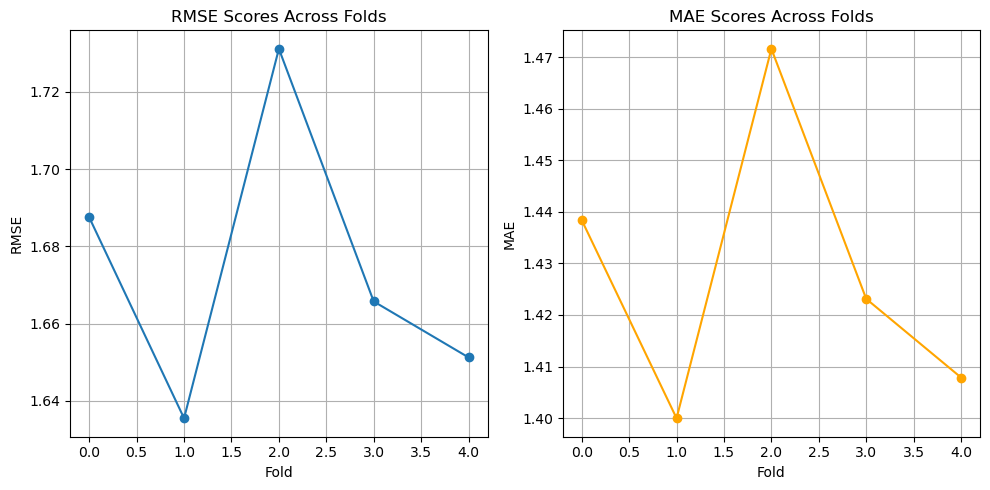

In [100]:
# Plot training loss across folds
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(rmse_scores, marker='o')
plt.title('RMSE Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mae_scores, marker='o', color='orange')
plt.title('MAE Scores Across Folds')
plt.xlabel('Fold')
plt.ylabel('MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
def plot_graph_sample(edge_index, n_users, n_items, sample_size=50):
    # Create NetworkX graph
    G = nx.Graph()

    # First get users who have interactions
    edges = edge_index.t().numpy()
    active_users = np.unique(edges[:, 0])

    # Sample from active users instead of all users
    sampled_users = np.random.choice(active_users, min(sample_size, len(active_users)), replace=False)

    # Get items connected to sampled users
    relevant_items = edges[np.isin(edges[:, 0], sampled_users), 1] - n_users
    sampled_items = np.random.choice(relevant_items, min(sample_size, len(relevant_items)), replace=False)

    # Add nodes with different colors for users and items
    for user in sampled_users:
        G.add_node(f'U{user}', bipartite=0)
    for item in sampled_items:
        G.add_node(f'I{item}', bipartite=1)

    # Add edges for sampled nodes
    edges = edge_index.t().numpy()
    for u, i in edges:
        if u in sampled_users and i-n_users in sampled_items:
            G.add_edge(f'U{u}', f'I{i-n_users}')

    # Create position layout
    pos = nx.spring_layout(G, k=1, iterations=50)

    plt.figure(figsize=(12, 8))
    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          nodelist=[n for n in G.nodes() if n.startswith('U')],
                          node_color='lightblue',
                          node_size=100,
                          label='Users')
    nx.draw_networkx_nodes(G, pos,
                          nodelist=[n for n in G.nodes() if n.startswith('I')],
                          node_color='lightgreen',
                          node_size=100,
                          label='Items')
    # Draw edges with transparency
    nx.draw_networkx_edges(G, pos, alpha=0.9, edge_color='black')

    plt.title(f'NGCF Bipartite Graph Structure\n(Sample of {sample_size} users and clothes)')
    plt.legend()
    plt.axis('off')
    plt.show()

In [ ]:
# Visualize the model
plot_graph_sample(train_edge_index, n_users, n_items, sample_size=50)

In [146]:
def get_model_recommendations(model, user_id, n_recommendations=10):
    model.eval()
    with torch.no_grad():
        # Convert user_id to encoded id
        encoded_user_id = user_encoder.transform([user_id])[0]

        # Create tensors for all possible items
        user_tensor = torch.LongTensor([encoded_user_id] * n_items)
        item_tensor = torch.LongTensor(np.arange(n_items))

        # Create temporary edge index that matches the model's expected structure
        source_nodes = torch.zeros(n_items, dtype=torch.long)  # All edges start from user 0
        target_nodes = torch.arange(n_items, dtype=torch.long)  # Connect to each item

        temp_edge_index = torch.stack([
            torch.cat([source_nodes, target_nodes]),
            torch.cat([target_nodes, source_nodes])
        ], dim=0)

        # Get predictions
        rating_pred = model(
            user_tensor,
            item_tensor,
            temp_edge_index
        )

        # Get top-N recommendations
        top_items = torch.argsort(rating_pred, descending=True)[:n_recommendations]
        predicted_ratings = rating_pred[top_items]

        # Convert back to original item IDs
        original_item_ids = item_encoder.inverse_transform(top_items.numpy())

        # Create recommendations dataframe
        recommendations = []
        for idx, item_id in enumerate(original_item_ids):
            item_data = dataset[dataset['item_id'] == item_id][['item_id', 'category', 'rented_for', 'rating', 'body_type']].iloc[0]
            item_data['predicted_rating'] = predicted_ratings[idx].item()
            recommendations.append(item_data)

        recommended_items = pd.DataFrame(recommendations)

    return recommended_items


In [129]:
# Example usage for a specific user
user_id = 420272  # Replace with desired user ID
recommendations = get_model_recommendations(model, user_id)

In [130]:
recommendations

,item_id,category,rented_for,rating,predicted_rating
3347,1662825,sheath,party,10.0,9.181025
223,148089,dress,wedding,10.0,9.173485
20079,221704,dress,other,8.0,9.172787
43530,2396986,coat,everyday,8.0,9.143108
17975,824029,dress,party,8.0,9.132826
349,1076484,dress,formal affair,8.0,9.127751
360,140321,gown,wedding,8.0,9.120347
52510,2180111,sweater,everyday,4.0,9.117706
14,123793,gown,formal affair,10.0,9.099997
2562,561264,sheath,wedding,8.0,9.095880


# Hybrid-recommendation:

In [121]:
def hybrid_recommendations(user_id, ngcf_model, annoy_index, n_recommendations=10, alpha=0.65):
    """
    Hybrid recommender combining NGCF and content-based recommendations
    alpha: weight for NGCF recommendations (1-alpha for content-based)
    """
    # Get NGCF recommendations
    ngcf_recs = get_model_recommendations(ngcf_model, user_id, n_recommendations=n_recommendations)

    # Get user's previously rated items
    user_items = dataset[dataset['user_id'] == user_id]['item_id'].values
    if len(user_items) == 0:
        return ngcf_recs  # Fall back to NGCF if no history

    # Get content-based recommendations for each item
    cb_recs_list = []
    for item_id in user_items:
        cb_recs = get_recommendations(annoy_index, item_id, n_recommendations=n_recommendations)
        cb_recs_list.append(cb_recs)

    # Combine content-based recommendations
    cb_recs_combined = pd.concat(cb_recs_list).drop_duplicates('item_id')

    # Normalize ratings
    ngcf_recs['normalized_rating'] = (ngcf_recs['predicted_rating'] - ngcf_recs['predicted_rating'].min()) / \
                                   (ngcf_recs['predicted_rating'].max() - ngcf_recs['predicted_rating'].min())
    cb_recs_combined['normalized_rating'] = (cb_recs_combined['rating'] - cb_recs_combined['rating'].min()) / \
                                          (cb_recs_combined['rating'].max() - cb_recs_combined['rating'].min())

    # Merge recommendations
    merged_recs = pd.merge(ngcf_recs, cb_recs_combined,
                          on=['item_id', 'category', 'rented_for'],
                          how='outer',
                          suffixes=('_ngcf', '_cb'))

    # Calculate hybrid scores
    merged_recs['hybrid_score'] = merged_recs.apply(
        lambda x: (alpha * x['normalized_rating_ngcf'] if pd.notnull(x['normalized_rating_ngcf']) else 0) +
                 ((1-alpha) * x['normalized_rating_cb'] if pd.notnull(x['normalized_rating_cb']) else 0),
        axis=1
    )

    # Sort and get top recommendations
    final_recs = merged_recs.nlargest(n_recommendations, 'hybrid_score')

    # Clean up output
    return final_recs[['item_id', 'category', 'rented_for', 'hybrid_score']]

In [122]:
# Example usage:
user_id = 420272
hybrid_recs = hybrid_recommendations(user_id, model, annoy_index)

In [123]:
hybrid_recs

,item_id,category,rented_for,hybrid_score
49,1662825,sheath,party,0.650000
35,1076484,dress,formal affair,0.593310
10,148089,dress,wedding,0.592441
17,221704,dress,other,0.587112
61,2396986,coat,everyday,0.360546
1,123793,gown,wedding,0.350000
2,126335,dress,party,0.350000
3,127865,gown,formal affair,0.350000
5,139086,gown,formal affair,0.350000
7,144714,gown,wedding,0.350000


In [51]:
selected_columns = ['rented_for', 'age', 'size', 'bust_size', 'category', 'rating', 'body_type', 'height','weight']
print(dataset[dataset['user_id'] == 420272][selected_columns].iloc[0])

rented_for     vacation
age                28.0
size                 14
bust_size           34d
category         romper
rating             10.0
body_type     hourglass
height           172.72
weight            137.0
Name: 0, dtype: object


In [52]:
print(dataset[dataset['item_id'] == 1662825][selected_columns].iloc[0])

rented_for        party
age                43.0
size                 14
bust_size           36d
category         sheath
rating             10.0
body_type     hourglass
height           162.56
weight            141.0
Name: 3347, dtype: object


In [143]:
# Define category mappings
clothing_categories = {
    'formal_wear': ['gown', 'suit', 'blazer', 'ballgown', 'sheath', 'dress', 'shirtdress'],
    'casual_tops': ['shirt', 't-shirt', 'blouse', 'tank', 'tee', 'henley', 'cami', 'turtleneck', 'buttondown', 'top', 'crewneck'],
    'outerwear': ['jacket', 'coat', 'trench', 'bomber', 'cape', 'vest', 'duster', 'poncho', 'cardigan', 'peacoat', 'overcoat', 'parka'],
    'bottoms': ['pants', 'trousers', 'jeans', 'leggings', 'culottes', 'skirt', 'skorts', 'tight', 'jogger', 'sweatpants', 'culotte', 'trouser'],
    'one_piece': ['romper', 'jumpsuit', 'overalls', 'maxi', 'midi', 'mini', 'kaftan', 'kimono', 'frock', 'tunic', 'caftan'],
    'athletic_wear': ['sweatshirt', 'hoodie', 'sweatershirt', 'legging', 'pullover', 'sweater', 'knit']
}

event_categories = {
    'category_1': ['everyday', 'work', 'date'],
    'category_2': ['wedding', 'vacation', 'formal affair'],
    'party': ['party', 'party: cocktail'],
    'other': ['other', 'Missing']
}

In [153]:
def get_category_group(item, categories_dict):
    for group, items in categories_dict.items():
        if any(category.lower() in item.lower() for category in items):
            return group
    return 'other'

def evaluate_recommendations(user_id, model, annoy_index):
    # Get user's actual data
    user_data = dataset[dataset['user_id'] == user_id].iloc[0]
    user_category_group = get_category_group(user_data['category'], clothing_categories)
    user_event_group = get_category_group(user_data['rented_for'], event_categories)
    user_body_type = user_data['body_type']

    # Get recommendations from both models
    gnn_recs = get_model_recommendations(model, user_id)
    content_recs = get_recommendations(annoy_index, user_data['item_id'])

    # Calculate matches for GNN
    gnn_category_matches = sum(get_category_group(rec['category'], clothing_categories) == user_category_group for _, rec in gnn_recs.iterrows())
    gnn_event_matches = sum(get_category_group(rec['rented_for'], event_categories) == user_event_group for _, rec in gnn_recs.iterrows())
    gnn_body_matches = sum(rec['body_type'] == user_body_type for _, rec in gnn_recs.iterrows())

    # Calculate matches for Content-based
    cb_category_matches = sum(get_category_group(rec['category'], clothing_categories) == user_category_group for _, rec in content_recs.iterrows())
    cb_event_matches = sum(get_category_group(rec['rented_for'], event_categories) == user_event_group for _, rec in content_recs.iterrows())
    cb_body_matches = sum(rec['body_type'] == user_body_type for _, rec in content_recs.iterrows())

    return {
        'gnn': {
            'category': gnn_category_matches / len(gnn_recs),
            'event': gnn_event_matches / len(gnn_recs),
            'body_type': gnn_body_matches / len(gnn_recs)
        },
        'content': {
            'category': cb_category_matches / len(content_recs),
            'event': cb_event_matches / len(content_recs),
            'body_type': cb_body_matches / len(content_recs)
        }
    }

In [ ]:
# Get unique users
unique_users = dataset['user_id'].unique()

# Calculate matches for all users
all_matches = {
    'gnn': {'category': [], 'event': [], 'body_type': []},
    'content': {'category': [], 'event': [], 'body_type': []}
}

for user_id in unique_users:
    try:
        matches = evaluate_recommendations(user_id, model, annoy_index)
        for model_type in ['gnn', 'content']:
            for feature in ['category', 'event', 'body_type']:
                all_matches[model_type][feature].append(matches[model_type][feature])
    except:
        continue

In [152]:
# Print average matches
avg_results = pd.DataFrame(results).mean()
print("\nAverage Matches Across All Users:")
print(f"Category Match: {avg_results['category_match']:.2f}%")
print(f"Event Match: {avg_results['event_match']:.2f}%")
print(f"Body Type Match: {avg_results['body_type_match']:.2f}%")


Average Matches Across All Users:
Category Match: 81.00%
Event Match: 56.00%
Body Type Match: 17.00%


In [4]:
print(dataset['rented_for'].dropna().unique())

NameError: name 'dataset' is not defined

In [133]:
print(dataset['category'].dropna().unique())

['romper' 'gown' 'sheath' 'dress' 'leggings' 'top' 'jumpsuit' 'sweater'
 'jacket' 'shirtdress' 'maxi' 'shift' 'pants' 'shirt' 'mini' 'skirt'
 'pullover' 'blouse' 'suit' 'coat' 'trench' 'bomber' 'cape' 'blazer'
 'vest' 'duster' 'ballgown' 'tank' 'poncho' 'frock' 'tunic' 'cardigan'
 'culottes' 'down' 'trouser' 'midi' 'pant' 'legging' 'print' 'knit'
 'culotte' 'sweatshirt' 'peacoat' 'kaftan' 'overalls' 'jogger' 'tee'
 'combo' 'henley' 'cami' 'blouson' 'turtleneck' 'trousers' 'overcoat'
 'hoodie' 't-shirt' 'caftan' 'tight' 'kimono' 'for' 'crewneck' 'skirts'
 'parka' 'buttondown' 'skort' 'sweatershirt' 'sweatpants' 'jeans']


In [148]:
print(dataset['body_type'].dropna().unique())

['hourglass' 'straight & narrow' 'Missing' 'pear' 'athletic' 'full bust'
 'petite' 'apple']
